In [ ]:
"""
Generator - PreTrained
Discriminator - Use a pretrained cracks detection model as discriminator
Train Disc and Gen (only last few layers of Gen)
"""

'\nGenerator - PreTrained\nDiscriminator - Use a pretrained cracks detection model as discriminator\nTrain Disc and Gen (only last few layers of Gen)\n'

# **Imports**

In [ ]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import tensorflow as tf
import os
import pandas as pd
from sklearn.utils import shuffle
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage import io
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary
from torchvision.datasets import ImageFolder

# **Generator**

PreTrained Generators : https://github.com/lukemelas/pytorch-pretrained-gans

In [ ]:
!pip install git+https://github.com/lukemelas/pytorch-pretrained-gans

  Cloning https://github.com/lukemelas/pytorch-pretrained-gans to /tmp/pip-req-build-xuxj6hgg
  Running command git clone --filter=blob:none --quiet https://github.com/lukemelas/pytorch-pretrained-gans /tmp/pip-req-build-xuxj6hgg
  Resolved https://github.com/lukemelas/pytorch-pretrained-gans to commit 2982fdab4e683165e45bc2f4a64c2942a7a3a1b7
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-gans: filename=pytorch_pretrained_gans-0.0.1-py3-none-any.whl size=183852 sha256=700d229d5c0b78217e9034180f3b2b95a832b3769bd49fb6e2c500980df486a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-a9m_xu_m/wheels/1d/8a/47/13f79126bd2899ff579333c8a7a907c35d1175f95174cec8a5
Successfully built pytorch-pretrained-gans


In [ ]:
! pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.3 MB/s eta 0:00:00


In [ ]:
from pytorch_pretrained_gans import make_gan

In [ ]:
# BigGAN (unconditional)
G = make_gan(gan_type='biggan', model_name='biggan-deep-128')  # -> nn.Module
# y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
# z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
# Move input tensors to the same device as the model (cuda or cpu)

Loading BigGAN model biggan-deep-128 from cache at /root/.pytorch_pretrained_biggan/6371c3777477e4e75187da1b9b526561aac3134f38c7299a3438009ae560e20d.3434ebdfa74a8c17e0e56061cfd905fa163c92f110e88df77b47da6ce9910b48


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z = torch.zeros(1, 128, device=device)
y = torch.zeros(1, 1000, device=device)

In [ ]:
x = G(z=z, y=y)  # -> torch.Size([1, 3, 256, 256])
assert z.shape == torch.Size([1, 128])
assert x.shape == torch.Size([1, 3, 128, 128])

In [ ]:
print(x.shape)

torch.Size([1, 3, 128, 128])


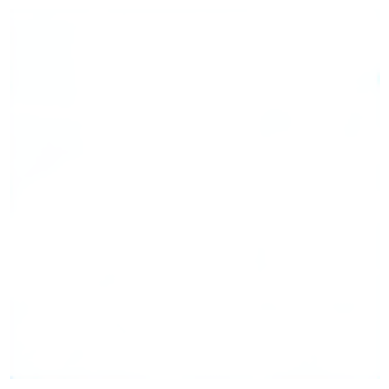

In [ ]:
x = x.detach().cpu().numpy()  # Move back to CPU for visualization
rgb_image = x[0].transpose(1, 2, 0)  # Shape: [128, 128, 3]


# Plot the image
plt.imshow(rgb_image)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
summary(G, input_size=[(128,), (1000,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         128,000
            Linear-2                [-1, 32768]       8,421,376
            Linear-3                 [-1, 2048]         524,288
            Linear-4                 [-1, 2048]         524,288
   BigGANBatchNorm-5           [-1, 2048, 4, 4]               0
              ReLU-6           [-1, 2048, 4, 4]               0
            Conv2d-7            [-1, 512, 4, 4]       1,049,088
            Linear-8                  [-1, 512]         131,072
            Linear-9                  [-1, 512]         131,072
  BigGANBatchNorm-10            [-1, 512, 4, 4]               0
             ReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       2,359,808
           Linear-13                  [-1, 512]         131,072
           Linear-14                  [

# **Discriminator**

In [ ]:
# # Data Preprocessing
# class CustomDataset(Dataset):
#     def __init__(self, df, transform=None):
#         self.df = df
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         img_name = self.df.iloc[idx, 0]
#         image = io.imread(img_name)
#         label = int(self.df.iloc[idx, 1])
#         if self.transform:
#             image = self.transform(image)
#         return image, label

In [ ]:
# import cv2
# import os
# import numpy as np

# def calculate_mean_std(folder_path):
#     # Initialize lists to store mean and standard deviation
#     means = []
#     stds = []

#     # Iterate through all files in the folder
#     for filename in os.listdir(folder_path):
#         if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
#             # Read the image
#             image = cv2.imread(os.path.join(folder_path, filename))

#             # Convert image to float32
#             image = image.astype(np.float32)

#             # Calculate mean and standard deviation
#             mean, std = cv2.meanStdDev(image)

#             # Append to lists
#             means.append(mean)
#             stds.append(std)

#     # Calculate overall mean and standard deviation
#     overall_mean = np.mean(means, axis=0)
#     overall_std = np.mean(stds, axis=0)

#     return overall_mean, overall_std

# # Folder paths
# positive_folder = '/content/Positive'
# negative_folder = '/content/Negative'

# # Calculate mean and standard deviation for positive images
# positive_mean, positive_std = calculate_mean_std(positive_folder)
# print("Positive Mean:", positive_mean)
# print("Positive Standard Deviation:", positive_std)

# # Calculate mean and standard deviation for negative images
# negative_mean, negative_std = calculate_mean_std(negative_folder)
# print("\nNegative Mean:", negative_mean)
# print("Negative Standard Deviation:", negative_std)

# #Calculating net mean
# print("\nNet Mean:",(positive_mean + negative_mean)/2)
# print("\nNet Standard Deviation:", (negative_std + positive_std)/2)



In [ ]:
# mean = [107.79140917/255, 130.11784592/255, 152.01397823/255]
# std = [14.87674105/255, 15.43544798/255, 15.69436533/255]

In [ ]:
# #Normalisation is skipped

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean, std),
# ])

In [ ]:
# #Viewing the transform
# from PIL import Image
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt

# # Define the transformation
# transform_ = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean, std),
# ])

# # Function to load and transform the image
# def load_and_transform_image(image_path, transform):
#     # Load the image
#     img = Image.open(image_path)
#     # Apply the transformation
#     transformed_img = transform(img)
#     return transformed_img

# image_path = "/content/Positive/00750.jpg"

# # Load and transform the image
# transformed_image = load_and_transform_image(image_path, transform_)

# # Convert tensor to numpy array and transpose the dimensions
# # to (height, width, channels) for visualization
# image_np = transformed_image.numpy().transpose((1, 2, 0))

# # Visualize the transformed image
# plt.imshow(image_np)
# plt.axis('off')
# plt.show()

In [ ]:
from torchvision.models import ResNet50_Weights

In [ ]:
# Define the model
class Rasnet50(nn.Module):
    def __init__(self):
        super(Rasnet50, self).__init__()
        self.resnet = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Sequential(
                  nn.Linear(2048, 512),
                  nn.ReLU(),
                  nn.BatchNorm1d(512),  # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(512, 512),
                  nn.ReLU(),
                  nn.BatchNorm1d(512),  # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(512, 256),
                  nn.ReLU(),
                  nn.BatchNorm1d(256),  # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(256, 256),
                  nn.ReLU(),
                  nn.BatchNorm1d(256),   # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(256, 128),
                  nn.ReLU(),
                  nn.BatchNorm1d(128),   # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(128, 128),
                  nn.ReLU(),
                  nn.BatchNorm1d(128),   # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(128, 64),
                  nn.ReLU(),
                  nn.BatchNorm1d(64),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(64, 64),
                  nn.BatchNorm1d(64),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(64, 32),
                  nn.BatchNorm1d(32),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(32, 32),
                  nn.BatchNorm1d(32),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(32, 16),
                  nn.BatchNorm1d(16),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(16, 2),
                  nn.Softmax(dim=1)  # Apply softmax layer
              )
    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D = Rasnet50()

In [ ]:
summary(D,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

# **Loading the dataset**

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d oluwaseunad/concrete-and-pavement-crack-images

100% 318M/319M [00:15<00:00, 23.2MB/s]
100% 319M/319M [00:15<00:00, 22.2MB/s]


In [ ]:
!unzip -q concrete-and-pavement-crack-images.zip

In [ ]:
!ls

concrete-and-pavement-crack-images.zip	drive  kaggle.json  Negative  Positive	sample_data


In [ ]:
import shutil

# Source and destination paths
source_folder_positive = "/content/Positive"
destination_folder = "/content/root/positive"

# Move positive folder to root folder
shutil.move(source_folder_positive, destination_folder)


'/content/root/positive'

# **Pipeline**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
disc = D.to(device)
gen = G.to(device)

In [ ]:
#Freeze disc layers
for param in disc.parameters():
    param.requires_grad = False
for param in disc.resnet.fc.parameters():
    param.requires_grad = True

In [ ]:
# Freeze all layers
for param in gen.parameters():
    param.requires_grad = False

# Unfreeze the last 20 layers
for param in list(gen.parameters())[-40:]:  #105
    param.requires_grad = True


In [ ]:
transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std),
])

In [ ]:
# Path to your dataset directory
dataset_root = "/content/root"

In [ ]:
#Hyper-paramaters
lr = 3e-4
batch_size = 16
num_epoch = 100

In [ ]:
# Create ImageFolder dataset instance
custom_dataset = ImageFolder(root=dataset_root, transform=transform)
loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

opt_disc = optim.Adam(disc.resnet.fc.parameters(),lr=lr)

# Filter out parameters for optimization
params_to_train = filter(lambda p: p.requires_grad, gen.parameters())
opt_gen = optim.Adam(params_to_train, lr=lr)
criterion = nn.BCELoss()

Epoch [0/100], Batch Step [0/938], Loss D: 1.7752, Loss G: 0.9494


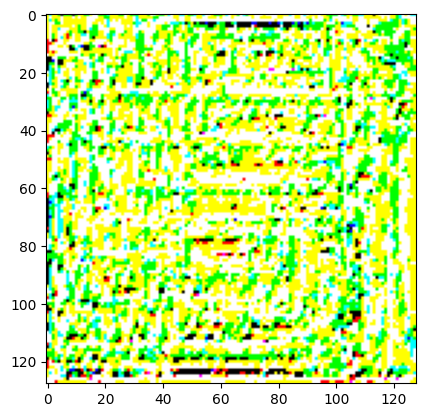

Epoch [1/100], Batch Step [0/938], Loss D: 1.3917, Loss G: 0.6948


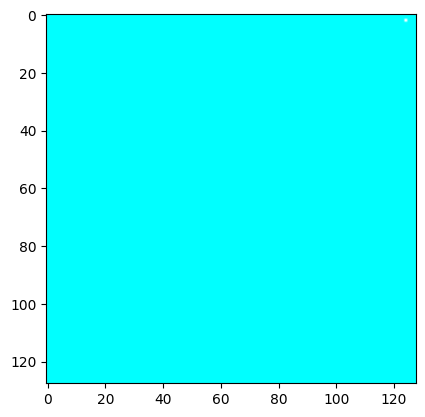

Epoch [2/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6932


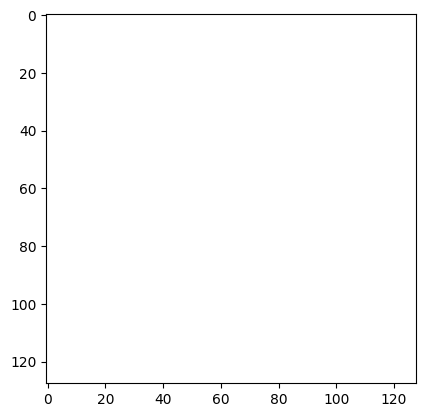

Epoch [3/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


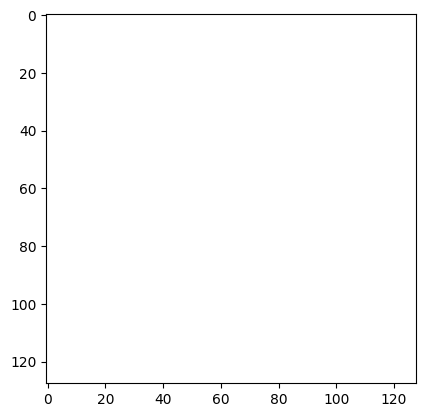

Epoch [4/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


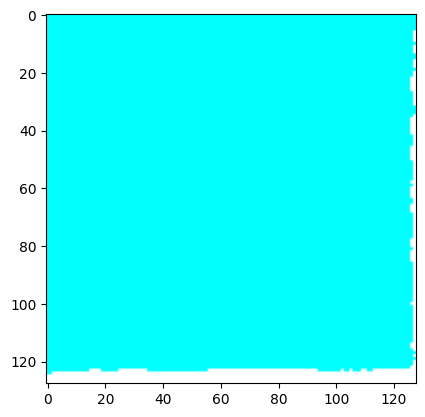

Epoch [5/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


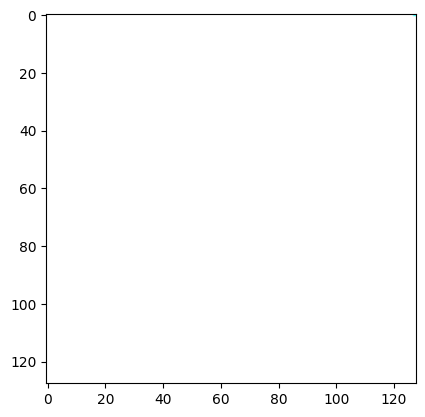

Epoch [6/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


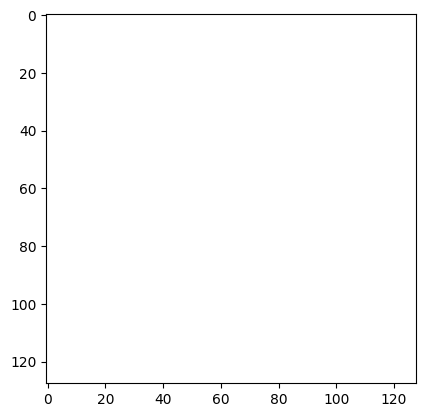

Epoch [7/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


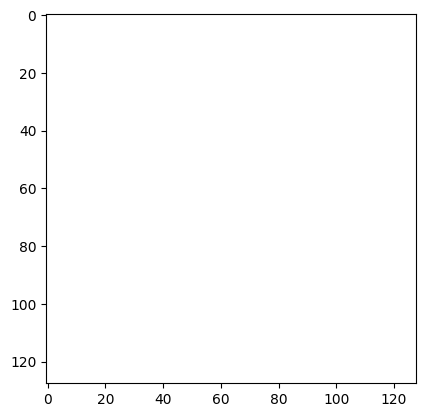

Epoch [8/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


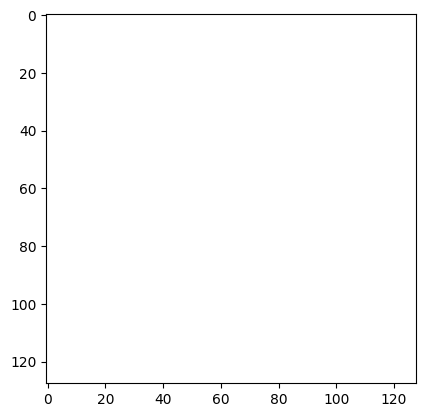

Epoch [9/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


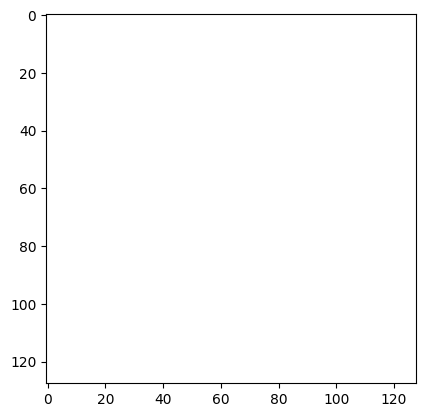

Epoch [10/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


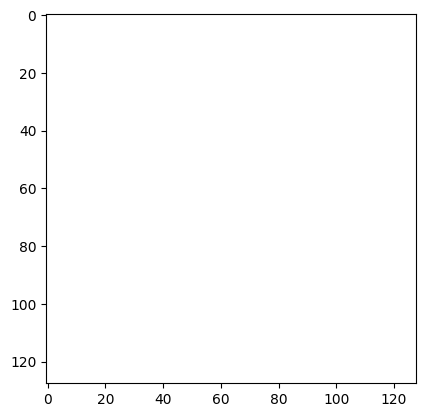

Epoch [11/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


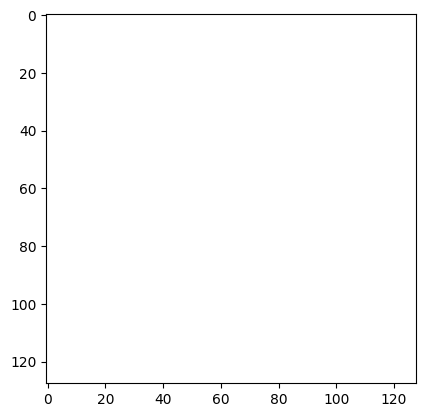

Epoch [12/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


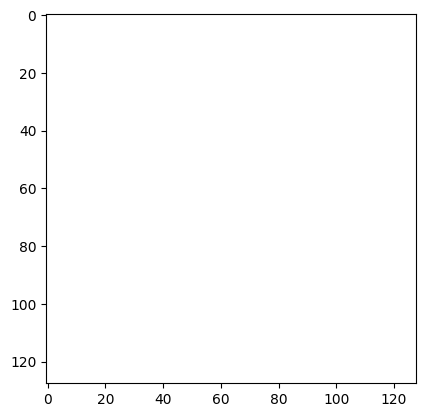

Epoch [13/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


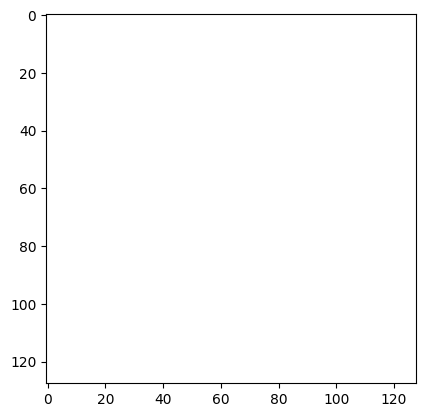

Epoch [14/100], Batch Step [0/938], Loss D: 1.3863, Loss G: 0.6931


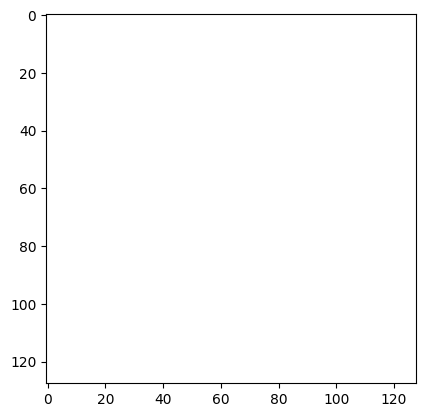

KeyboardInterrupt: 

In [ ]:
step = 0
for epoch in range(num_epoch):
  for batch_idx,(real,_) in enumerate(loader):

    batch_size = real.shape[0]
    real = real.to(device)


    #Discriminator : max log(D(real)) + log(1-D(G(z)))

    #real
    disc_real = disc(real)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))

    #fake
    # noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
    noise_z = torch.randn(1, 128).to(device)
    noise_y = torch.randn(1, 1000).to(device)
    fake = gen(z=noise_z.expand(batch_size, -1), y=noise_y.expand(batch_size, -1))
    disc_fake = disc(fake.detach())
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    lossD = (lossD_real + lossD_fake)
    disc.zero_grad()
    lossD.backward(retain_graph = True)
    opt_disc.step()

    # Train Generator min log(1-D(G(z)))
    output = disc(fake)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    #Plotting
    if batch_idx % 1000 == 0:
        print(f"Epoch [{epoch}/{num_epoch}], Batch Step [{batch_idx}/{len(loader)}], Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

        # Plot the generated images
        fig, ax = plt.subplots()
        ax.imshow(fake[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')

        plt.show()

In [ ]:
noise_z = torch.ones(1, 128).to(device)
noise_y = torch.ones(1, 1000).to(device)
fake = gen(z=noise_z.expand(batch_size, -1), y=noise_y.expand(batch_size, -1))

In [ ]:
x = G(z=z, y=y)  # -> torch.Size([1, 3, 256, 256])
assert z.shape == torch.Size([1, 128])
assert x.shape == torch.Size([1, 3, 128, 128])

In [ ]:
print(x.shape)

torch.Size([1, 3, 128, 128])


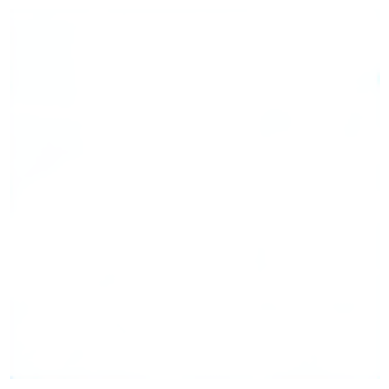

In [ ]:
x = x.detach().cpu().numpy()  # Move back to CPU for visualization
rgb_image = x[0].transpose(1, 2, 0)  # Shape: [128, 128, 3]


# Plot the image
plt.imshow(rgb_image)
plt.axis('off')  # Hide axes
plt.show()